In [ ]:
import numpy as np 
import pandas as pd 
from collections import Counter
import os
print(os.listdir("../input"))


In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from fastai.vision import *
from fastai.metrics import *

import numpy as np
np.random.seed(7)

import torch
torch.cuda.manual_seed_all(7)


In [ ]:
tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=20., max_zoom=0.05)
len(tfms)

In [ ]:
path = '../input/IDC_regular_ps50_idx5/'
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, valid_pct=0.2,
                                  size=48, bs=128).normalize(imagenet_stats)

data.show_batch()

0 indicates `no IDC` (no breast cancer) while 1 indicates `IDC`  (breast cancer) 

IDC -> Invasive Ductal Carcinoma

## Distribution of the classes in the training and validation splits

In [21]:
train_counts = Counter(data.train_ds.y)
train_counts.most_common()

[(Category 0, 159089), (Category 1, 62931)]

In [22]:
valid_counts = Counter(data.valid_ds.y)
valid_counts.most_common()

[(Category 0, 39649), (Category 1, 15855)]

In [23]:
data.label_list

LabelLists;

Train: LabelList (222020 items)
x: ImageList
Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48)
y: CategoryList
1,1,1,1,1
Path: ../input/IDC_regular_ps50_idx5;

Valid: LabelList (55504 items)
x: ImageList
Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48)
y: CategoryList
0,1,0,0,0
Path: ../input/IDC_regular_ps50_idx5;

Test: None

## Looking at a few samples 

(Image (3, 48, 48), Category 1)


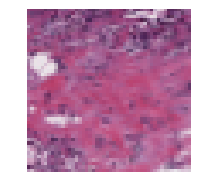

In [24]:
print(data.train_ds[0]);
show_image(data.train_ds[0][0], figsize=(3,3))

(Image (3, 48, 48), Category 1)


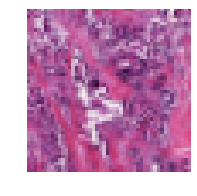

In [25]:
print(data.train_ds[5]);
show_image(data.train_ds[5][0],)

(Image (3, 48, 48), Category 0)


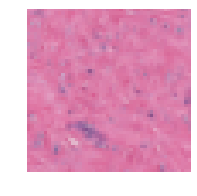

In [26]:
print(data.train_ds[45]);
show_image(data.train_ds[45][0])

(Image (3, 48, 48), Category 0)


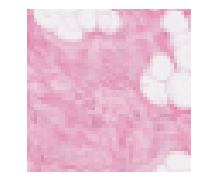

In [27]:
print(data.valid_ds[45]);
show_image(data.valid_ds[45][0])

(Image (3, 48, 48), Category 0)


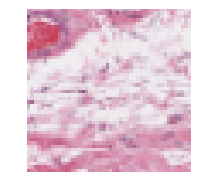

In [28]:
print(data.valid_ds[53]);
show_image(data.valid_ds[53][0])

(Image (3, 48, 48), Category 0)


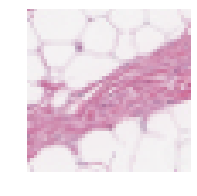

In [29]:
print(data.valid_ds[105]);
show_image(data.valid_ds[105][0])

(Image (3, 48, 48), Category 0)


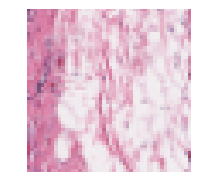

In [30]:
print(data.valid_ds[598]);
show_image(data.valid_ds[598][0])

(Image (3, 48, 48), Category 1)


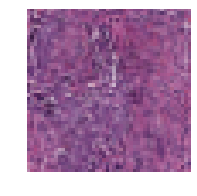

In [31]:
print(data.valid_ds[928]);
show_image(data.valid_ds[928][0])

In [ ]:
from torch import nn

weights = [0.4, 1]
class_weights=torch.FloatTensor(weights).cuda()

In [ ]:
# Begin the training
learn = cnn_learner(data, models.resnet50, metrics=[accuracy], model_dir='/tmp/models').to_fp16()
learn.loss_func = nn.CrossEntropyLoss(weight=class_weights)
learn.lr_find()
learn.recorder.plot()


In [ ]:
learn.fit_one_cycle(5, max_lr=slice(1e-04, 1e-05));
learn.recorder.plot_losses()

In [ ]:
del learn

In [ ]:
learn = cnn_learner(data, models.resnet50, metrics=[accuracy], model_dir='/tmp/models').to_fp16()
learn.loss_func = nn.CrossEntropyLoss(weight=class_weights)

In [ ]:
learn.fit_one_cycle(5, max_lr=slice(1e-03, 1e-04));
learn.recorder.plot_losses()

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(5,5))

In [ ]:
from sklearn.metrics import classification_report

def return_classification_report(learn):
    
    ground_truth = []
    pred_labels = []

    for i in range(len(learn.data.valid_ds)):
        temp_pred = str(learn.predict(learn.data.valid_ds[i][0])[0])
        temp_truth = str(learn.data.valid_ds[i]).split('), ', 1)[1].replace('Category ', '').replace(')', '')
        pred_labels.append(temp_pred)
        ground_truth.append(temp_truth)

    assert len(pred_labels) == len(ground_truth)
    
    return classification_report(ground_truth, pred_labels, target_names=data.classes)

In [ ]:
print(return_classification_report(learn))

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr = slice(1e-03))

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(5,5))

In [ ]:
print(return_classification_report(learn))